In [1]:
import sys, os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patch
import cartopy.crs as ccrs

from typing import NamedTuple

from scipy.stats import pearsonr
from functools import partial

import warnings
warnings.filterwarnings('ignore')

sys.path.append(constants.MODULE_DIR)

import signal_to_noise as sn

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))

import constants

In [4]:
os.listdir(constants.LONGRUNMIP_DIR)

['tas',
 'surf',
 'netTOA',
 'sic_aso',
 'sic_fma',
 'zarr_test',
 'landesea_masks',
 'tos',
 'pr',
 '.ipynb_checkpoints',
 'psl',
 'sic']

In [82]:
os.listdir(os.path.join(constants.LONGRUNMIP_DIR, 'psl', 'regrid_retimestamped'))[:5]

['psl_mon_GISSE2R_control_5225_g025.nc',
 'psl_mon_CESM104_control_1000_g025.nc',
 'psl_ann_HadGEM2ES_abrupt4x_1299_g025.nc',
 'psl_mon_GISSE2R_abrupt4x_5001_g025.nc',
 'psl_ann_FAMOUS_abrupt4x_3000_g025.nc']

In [9]:
open_kwargs = dict(use_cftime=True)

In [11]:
abrupt_ds = xr.open_dataset(os.path.join(constants.LONGRUNMIP_DIR, 'psl', 'regrid', 'psl_mon_CESM104_abrupt4x_5900_g025.nc'), 
                           **open_kwargs).isel(time=slice(None, 1000))

In [38]:
contol_ds = xr.open_dataset(os.path.join(constants.LONGRUNMIP_DIR, 'psl', 'regrid', 'psl_mon_CESM104_control_1000_g025.nc'),
                           **open_kwargs)

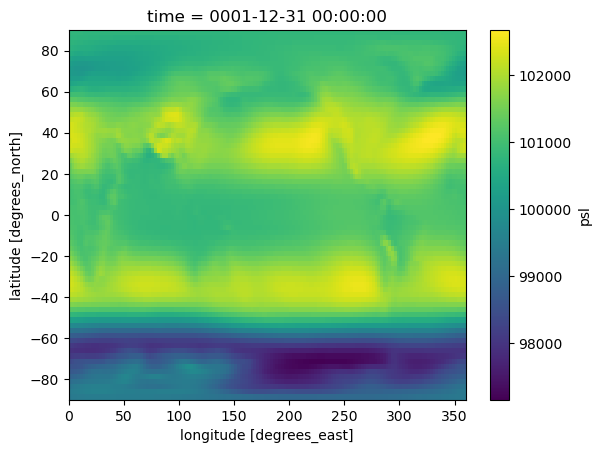

In [39]:
abrupt_ds.psl.isel(time=0).plot()

In [90]:
def calculate_aoi_index(da):
    '''
    Index is calculated from
    https://journals.ametsoc.org/view/journals/clim/16/24/1520-0442_2003_016_4134_titsam_2.0.co_2.xml
    
    '''
    da_40 = da.psl.sel(lat=-40,  method='nearest').mean(dim='lon')/da.psl.sel(lat=-40,  method='nearest').mean()
    da_65 = da.psl.sel(lat=-65,  method='nearest').mean(dim='lon')/da.psl.sel(lat=-65,  method='nearest').mean()

    aoi_da = da_40 - da_65
    
    return aoi_da

In [91]:
control_aoi = calculate_aoi_index(contol_ds)

In [92]:
abrupt_aoi = calculate_aoi_index(abrupt_ds)

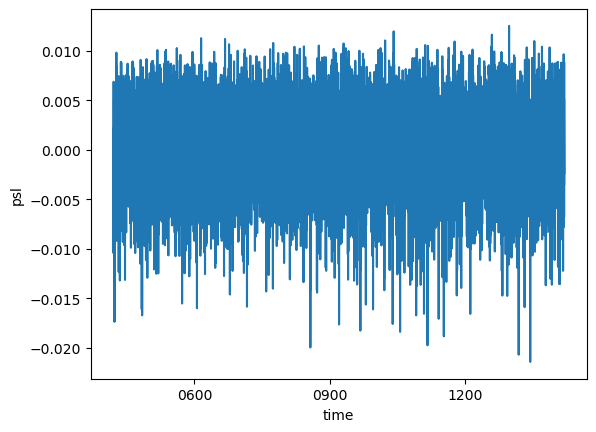

In [96]:
control_aoi.plot()

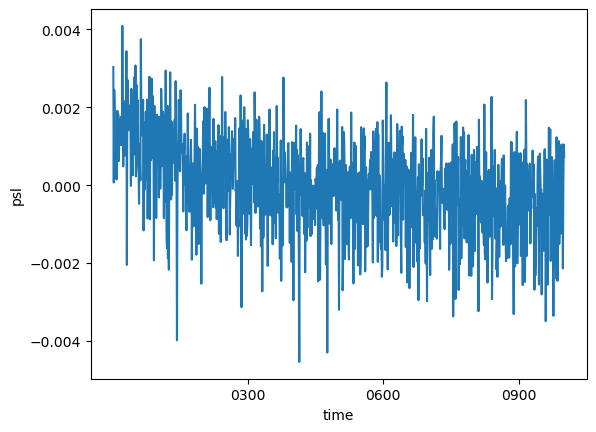

In [93]:
abrupt_aoi.plot()

In [87]:


sn.multiwindow_signal_to_nosie_and_bounds

<function signal_to_noise.multiwindow_signal_to_nosie_and_bounds(experiment_da: xarray.core.dataarray.DataArray, control_da: xarray.core.dataarray.DataArray, da_for_noise: Optional[xarray.core.dataarray.DataArray] = None, rolling_noise=True, time_slice: Tuple[int] = None, windows: Optional[Tuple[int]] = None, start_window: int = 21, end_window: Optional[int] = None, step_window: Optional[int] = None, detrend: bool = True, detrend_kwargs: Optional[Dict] = {}, parallel=False, logginglevel='INFO', return_all=False, return_control: bool = False) -> xarray.core.dataset.Dataset>

In [88]:
aoi_stability_ds = sn_multi_static_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    abrupt_aoi, control_aoi,
    rolling_noise=True, detrend=True, detrend_kwargs = dict(method='polynomial', order=5),
    logginglevel='ERROR', return_all=True, windows=[21, 41, 61, 81])


Experiment
--------
21, 41, 61, 81, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

21, 41, 61, 81, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge


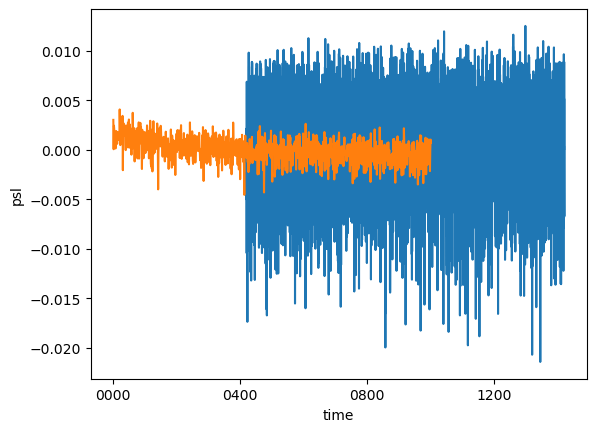

In [94]:
control_aoi.plot()
abrupt_aoi.plot()

In [65]:
import sn_plotting

In [72]:
sn_plotting.two_line_highlight_plot

<function sn_plotting.two_line_highlight_plot(left_ds: xarray.core.dataarray.DataArray = None, right_ds: xarray.core.dataarray.DataArray = None, left_highlight_ds: xarray.core.dataarray.DataArray = None, right_highlight_ds: xarray.core.dataarray.DataArray = None, left_label=None, right_label=None, bounds: Dict[str, float] = None)>

In [77]:
aoi_stability_ds.lower_bound.values

array([-2.09119779, -1.69736426, -1.42547762, -1.18799964])

(<Figure size 1500x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Time after net zero emissions (years)', ylabel='AOI'>,
 <AxesSubplot:xlabel='Time after net zero emissions (years)', ylabel='S/N'>)

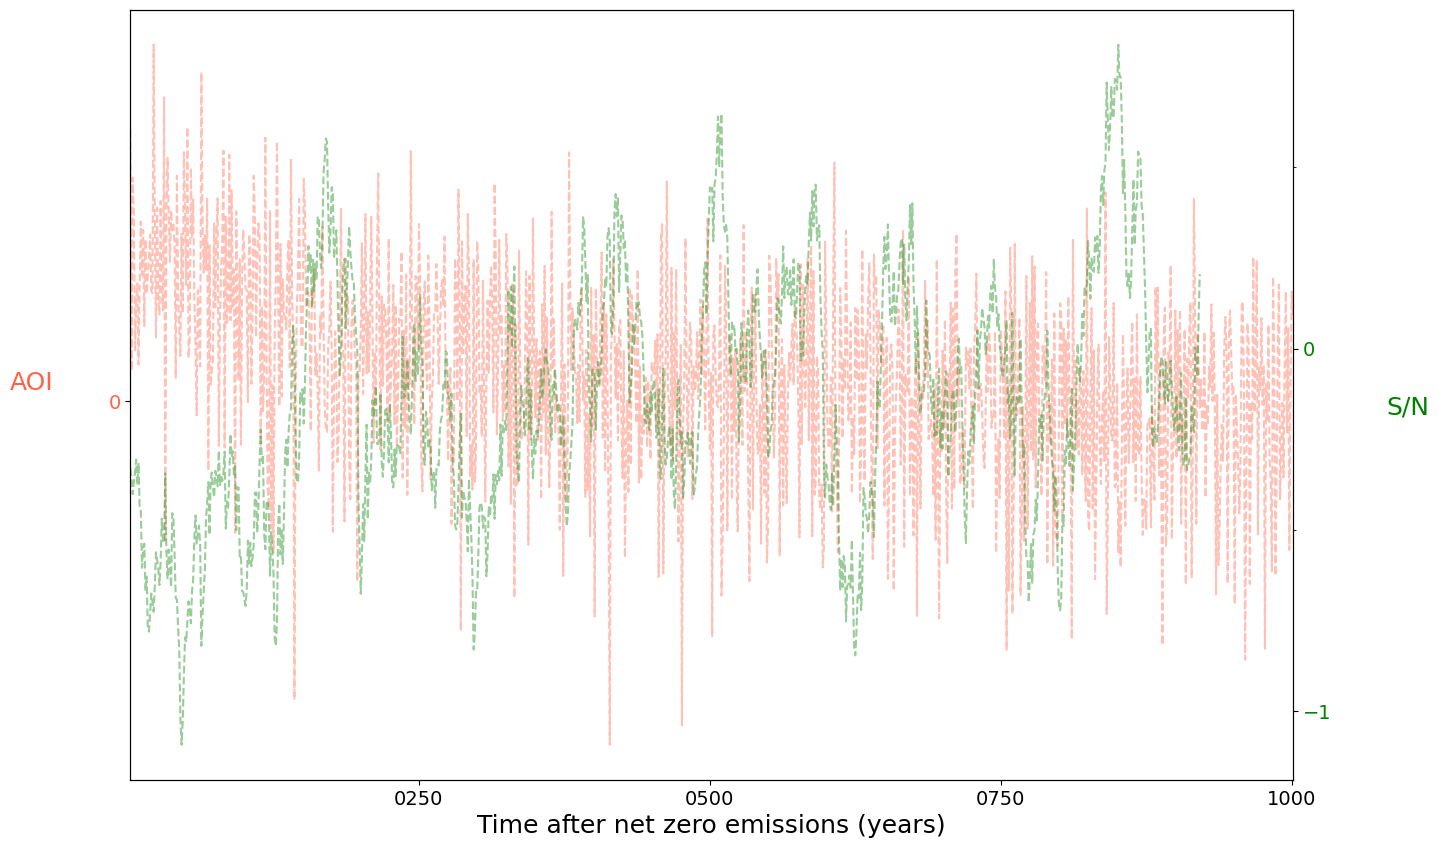

In [80]:
sn_plotting.two_line_highlight_plot(abrupt_aoi, aoi_stability_ds.sel(window=81).signal_to_noise, 
                                   left_label='AOI', right_label='S/N', 
                                   # bounds={'lower':aoi_stability_ds.sel(window=81).lower_bound.values,
                                   #         'upper':aoi_stability_ds.sel(window=81).upper_bound.values}
                                   )

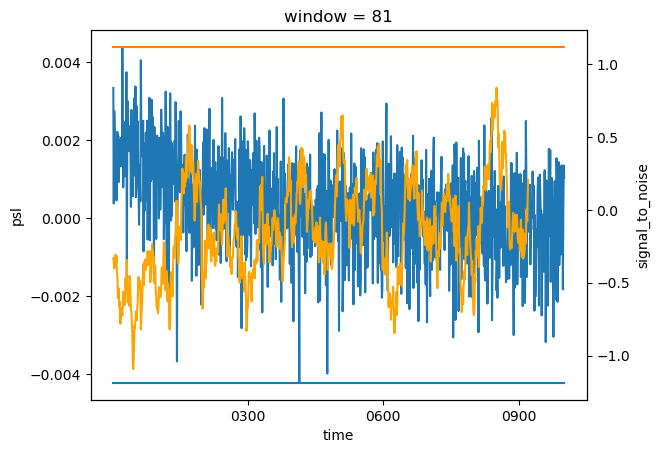

In [61]:
fig = plt.figure()
ax = plt.axes()
abrupt_aoi.plot(ax=ax)
ax2 = ax.twinx()
aoi_stability_ds_subset = aoi_stability_ds.sel(window=81)
aoi_stability_ds_subset.signal_to_noise.plot(ax=ax2, color='orange')
ax2.plot(aoi_stability_ds_subset.time.values, [aoi_stability_ds_subset.lower_bound.values]*len(aoi_stability_ds_subset.time.values))
ax2.plot(aoi_stability_ds_subset.time.values, [aoi_stability_ds_subset.upper_bound.values]*len(aoi_stability_ds_subset.time.values))